# Escuela-Congreso 100YQR: Protocolos de Información & Computación Cuántica Usando Fotones

---

## Sesión 4 Taller (01-10-2025)

---

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

## Simulación de Interferómetro de Mach-Zehnder

En esta sesión, simularemos un interferómetro de Mach-Zehnder usando la librería Strawberry Fields desarrollada por la empresa canadiense Xanadu Quantum Technologies. La documentación de esta librería pueden encontrarla en https://strawberryfields.readthedocs.io/en/stable/.

In [181]:
#!pip3 install 'numpy==1.26.4'
#!pip3 install 'numba<0.62.0a0,>=0.59.1'
#!pip3 install 'sympy==1.13.1'
#!pip3 install 'networkx==3.3'
!pip3 install 'scipy==1.13.1'
!pip3 install strawberryfields --no-deps
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt

# set the random seed
np.random.seed(42)

In [182]:
n_paths = 2 # number of independent paths in the interferometer, for a Mach-Zehnder, this number is two
n_modes = n_paths # here, a factor of two must be included if we want to take polarization degrees of freedom into account
cutoff_dim = 2 # this means we will be using only 1 (=cutoff_dim - 1) photons per run, that is, single-photon interferometry

#======== Initial State Preparation ==========

# Zero State
ZeroState = np.zeros([cutoff_dim] * n_modes, dtype='complex')

# Single-photon states with determined path

InitialState1 = np.copy(ZeroState)
InitialState1[1,0] = 1 # state with one photon in the first path

InitialState2 = np.copy(ZeroState)
InitialState2[0,1] = 1 # state with one photon in the second path

#============ Gate Construction =============

SWAP = Interferometer(np.array([[0,1],[1,0]]))

def HWP(angle):
    x = np.cos(2*angle)
    y = np.sin(2*angle)
    return Interferometer(np.array([[x,y],[y,-x]]))


In [183]:
# in these arrays, each dimension represents a path, and how far away they are from the "top-left" corner the photon number
# for a bigger number of modes, visualizing these matrices can be rather confusing
print(InitialState1)
print('='*20)
print(InitialState2)

[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]


### Simulación del estado final (sin medición)

En esta parte haremos una simulación numérica del estado que se obtiene al final del interferómetro de Mach-Zehnder. Esto nos permitirá calcular el patrón de interferencia en las probabilidades de detección.

In [184]:
prog = sf.Program(n_modes)
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
phi = prog.params('phi') # phase difference parameter

with prog.context as q:
    # prepare initial state
    Ket(InitialState1) | q

    # apply gates
    BSgate() | (q[0], q[1]) # first beam splitter
    Rgate(phi) | q[1] # introduce relative phase
    BSgate() | (q[0], q[1]) # second beam splitter

    # count photons
    #MeasureFock() | q # if we measure the number of photons, we destroy the state and cannot obtain the outcome probability distributions

In [185]:
phi_range = np.linspace(0, 2*np.pi, 25)

PD1 = []
PD2 = []

for phase in phi_range:
    result = eng.run(prog, shots=1, args={'phi': phase })

    # the result.state object contains all information about the final state and has many useful methods
    # here, we will only use the all_fock_probs method which gives us the probabilities associated to a Fock basis measurement

    p_dist = result.state.all_fock_probs()

    PD1.append(p_dist[1,0]) # pobability of finding the photon at first path
    PD2.append(p_dist[0,1]) # probability of finding the photon at second path

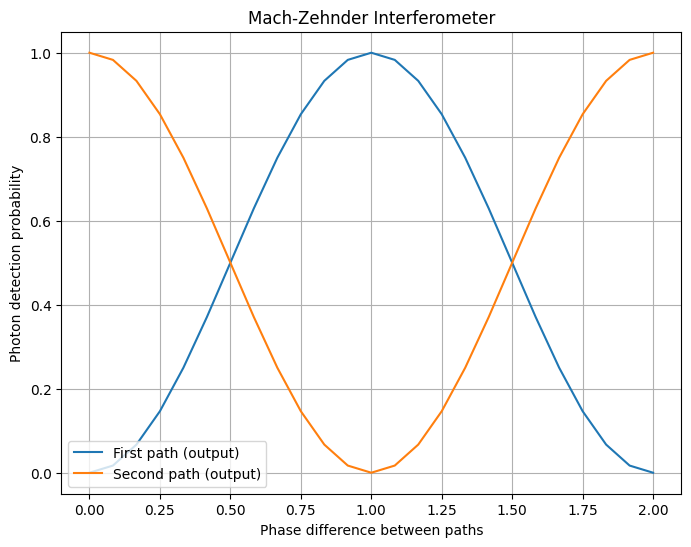

In [186]:
plt.figure(figsize=(8,6))
plt.title("Mach-Zehnder Interferometer")
plt.plot(phi_range/np.pi, PD1, label="First path (output)")
plt.plot(phi_range/np.pi, PD2, label="Second path (output)")
plt.xlabel("Phase difference between paths")
plt.ylabel("Photon detection probability")
plt.legend(loc="lower left")
plt.grid()
plt.show()

### Simulación de muestras

En esta parte haremos una simulación numérica de las muestras que nos arrojarían los detectores de fotones al final del interferómetro de Mach-Zehnder. Esta simulación se acerca más al caso real que se mediría en el laboratorio.

In [187]:
prog = sf.Program(n_modes)
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
phi = prog.params('phi') # phase difference parameter

with prog.context as q:
    # prepare initial state
    Ket(InitialState1) | q

    # apply gates
    BSgate() | (q[0], q[1]) # first beam splitter
    Rgate(phi) | q[1] # introduce relative phase
    BSgate() | (q[0], q[1]) # second beam splitter

    # count photons
    MeasureFock() | q # now we do count the photons in the end!

In [188]:
n_shots = 50 # number of runs per sample of the single-photon interferometer
n_samples = 10 # number of samples

N1 = np.zeros((len(phi_range), n_samples))
N2 = np.zeros((len(phi_range), n_samples))

for i in range(len(phi_range)):

  for j in range(n_samples):
    counts1 = 0
    counts2 = 0

    for _ in range(n_shots):
        result = eng.run(prog, shots=1, args={'phi': phi_range[i] })
        samp = result.samples[0]
        counts1 += samp[0]
        counts2 += samp[1]

    N1[i,j] = counts1 # number of photons in first path
    N2[i,j] = counts2 # number of photons in second path

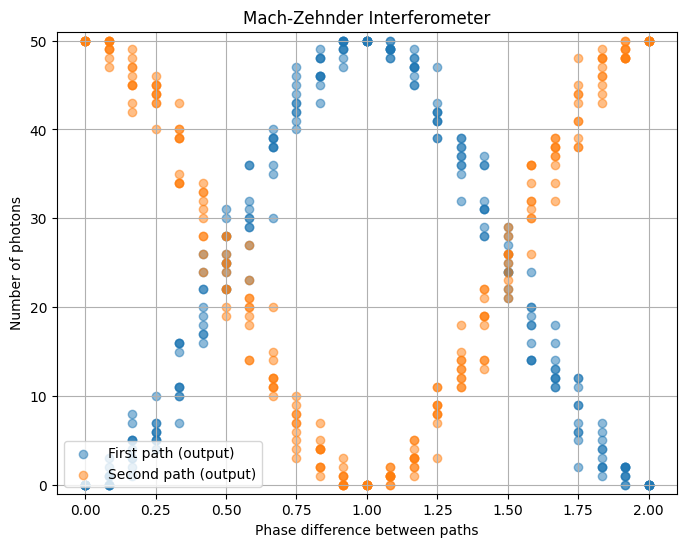

In [189]:
plt.figure(figsize=(8,6))
plt.title("Mach-Zehnder Interferometer")

for x, y in zip(phi_range/np.pi, N1):
    plt.scatter([x] * len(y), y, color="C0", alpha=0.5, label="First path (output)" if x == 0 else "")

for x, y in zip(phi_range/np.pi, N2):
    plt.scatter([x] * len(y), y, color="C1", alpha=0.5, label="Second path (output)" if x == 0 else "")

# plt.scatter(phi_range/np.pi, N1.T, label="First path (output)", color="C0", alpha=0.5)
# plt.scatter(phi_range/np.pi, N2.T, label="Second path (output)", color="C1", alpha=0.5)
plt.xlabel("Phase difference between paths")
plt.ylabel("Number of photons")
plt.ylim([-1,51])
plt.legend(loc="lower left")
plt.grid()
plt.show()

Esta interferencia pone en manifestación la naturaleza ondulatoria de la luz. Si removiéramos el último divisor de haz, observaríamos el comportamiento corspuscular de la misma.

In [190]:
prog = sf.Program(n_modes)
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
phi = prog.params('phi') # phase difference parameter

with prog.context as q:
    # prepare initial state
    Ket(InitialState1) | q

    # apply gates
    BSgate() | (q[0], q[1]) # first beam splitter
    Rgate(phi) | q[1] # introduce relative phase

    # count photons
    MeasureFock() | q

In [191]:
n_shots = 50 # number of runs per sample of the single-photon interferometer
n_samples = 10 # number of samples

N1 = np.zeros((len(phi_range), n_samples))
N2 = np.zeros((len(phi_range), n_samples))

for i in range(len(phi_range)):

  for j in range(n_samples):
    counts1 = 0
    counts2 = 0

    for _ in range(n_shots):
        result = eng.run(prog, shots=1, args={'phi': phi_range[i] })
        samp = result.samples[0]
        counts1 += samp[0]
        counts2 += samp[1]

    N1[i,j] = counts1 # number of photons in first path
    N2[i,j] = counts2 # number of photons in second path

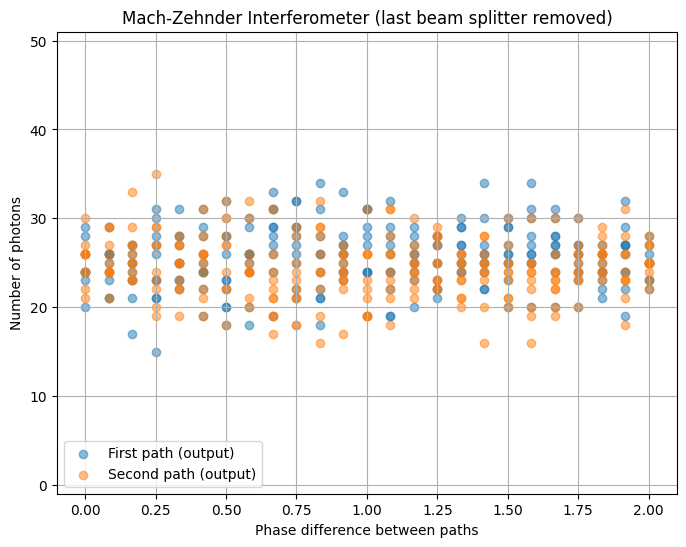

In [192]:
plt.figure(figsize=(8,6))
plt.title("Mach-Zehnder Interferometer (last beam splitter removed)")

for x, y in zip(phi_range/np.pi, N1):
    plt.scatter([x] * len(y), y, color="C0", alpha=0.5, label="First path (output)" if x == 0 else "")

for x, y in zip(phi_range/np.pi, N2):
    plt.scatter([x] * len(y), y, color="C1", alpha=0.5, label="Second path (output)" if x == 0 else "")

# plt.scatter(phi_range/np.pi, N1.T, label="First path (output)", color="C0", alpha=0.5)
# plt.scatter(phi_range/np.pi, N2.T, label="Second path (output)", color="C1", alpha=0.5)
plt.xlabel("Phase difference between paths")
plt.ylabel("Number of photons")
plt.ylim([-1,51])
plt.legend(loc="lower left")
plt.grid()
plt.show()

> Ejercicio: Simule el interferómetro Mach-Zehnder con un divisor de haz sintonizable implementado a través de un interferómetro de Sagnac y grafique la probabilidad de detectar un fotón en uno de los detectores en función de las diferencias relativas de fase de cada interferómetro (es decir, un plot bidimensional barriendo sobre el espacio de parámetros)

In [195]:
prog = sf.Program(n_modes)
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})
phi_mz = prog.params('phi_mz') # phase difference parameter for the Mach-Zehnder interferometer
phi_s = prog.params('phi_s') # phase difference parameter for the Sagnac inteferometer

with prog.context as q:
    # prepare initial state
    Ket(InitialState1) | q

    # apply gates
    BSgate(phi=np.pi/2) | (q[0], q[1]) # first beam splitter, now we have defined it to be symmetric
    Rgate(phi_mz) | q[1] # introduce relative Mach-Zehnder phase
    BSgate(phi=np.pi/2) | (q[0], q[1]) # second beam splitter
    Rgate(phi_s) | q[0] # introduce relative Sagnac phase
    BSgate(phi=np.pi/2) | (q[0], q[1]) # second beam splitter, again

    # count photons
    #MeasureFock() | q # if we measure the number of photons, we destroy the state and cannot obtain the outcome probability distributions

In [197]:
phi_range = np.linspace(0, 2*np.pi, 25)

PD1 = np.zeros((len(phi_range), len(phi_range)))
PD2 = np.zeros((len(phi_range), len(phi_range)))

for i in range(len(phi_range)):
  for j in range(len(phi_range)):
    result = eng.run(prog, shots=1, args={'phi_mz': phi_range[i] , 'phi_s': phi_range[j]})

    p_dist = result.state.all_fock_probs()

    PD1[i,j] = p_dist[1,0] # pobability of finding the photon at first path
    PD2[i,j] = p_dist[0,1] # probability of finding the photon at second path

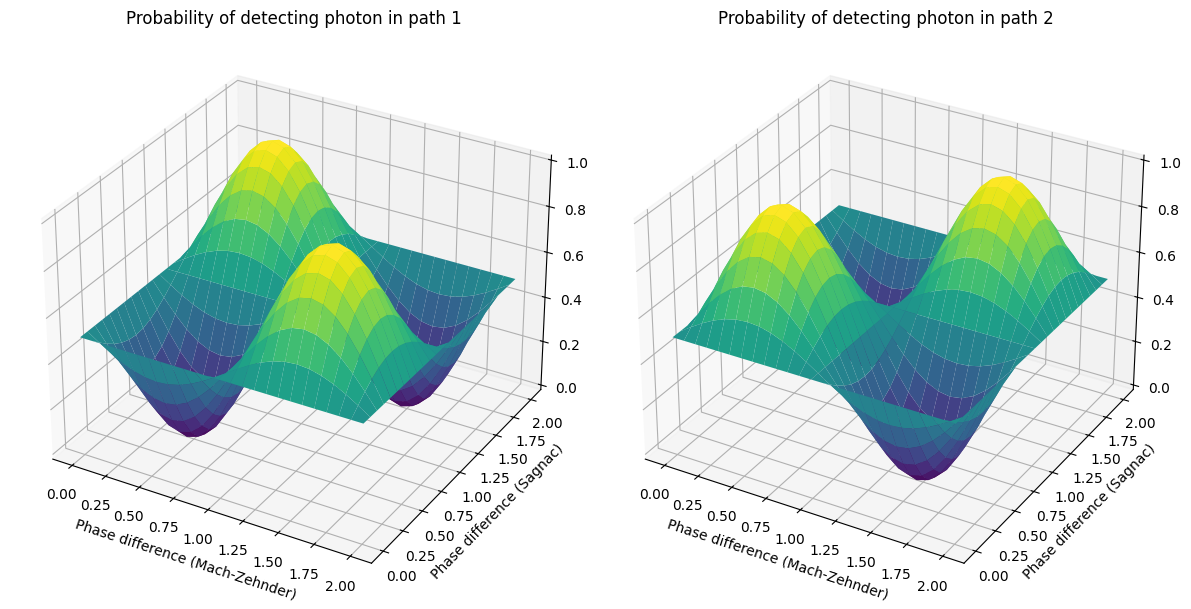

In [233]:
from mpl_toolkits.mplot3d import Axes3D

phi_mz_mesh, phi_s_mesh = np.meshgrid(phi_range, phi_range)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(phi_mz_mesh/np.pi, phi_s_mesh/np.pi, PD1, cmap='viridis')
ax1.set_xlabel('Phase difference (Mach-Zehnder)')
ax1.set_ylabel('Phase difference (Sagnac)')
ax1.set_title('Probability of detecting photon in path 1')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(phi_mz_mesh/np.pi, phi_s_mesh/np.pi, PD2, cmap='viridis')
ax2.set_xlabel('Phase difference (Mach-Zehnder)')
ax2.set_ylabel('Phase difference (Sagnac)')
ax2.set_title('Probability of detecting photon in path 2')

plt.tight_layout()
plt.show()

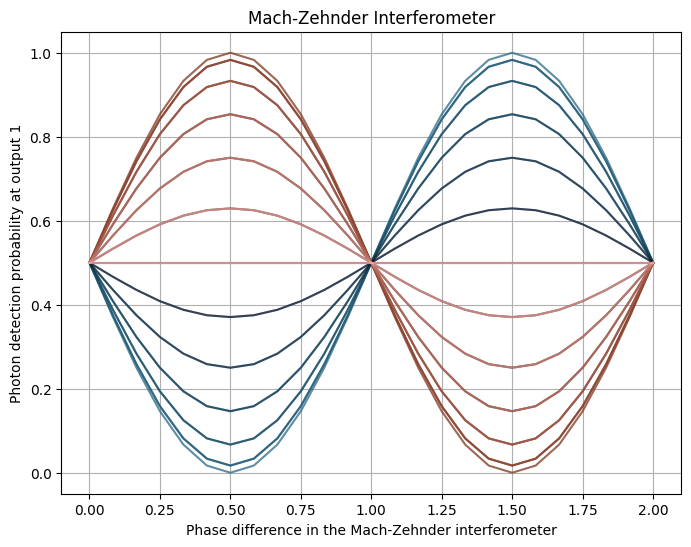

In [248]:
import matplotlib.cm as cm

plt.figure(figsize=(8,6))
plt.title("Mach-Zehnder Interferometer")

colors = cm.berlin(np.linspace(0, 1, len(phi_range)))

for j in range(len(phi_range)):
  plt.plot(phi_range/np.pi, PD1[:,j], color=colors[j], alpha=0.75)

plt.xlabel("Phase difference in the Mach-Zehnder interferometer")
plt.ylabel("Photon detection probability at output 1")
plt.grid()
plt.show()